<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/.addixo/6_Generation_Classification_Interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo_final_dataset_fs_db.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['label'], axis=1, inplace=True)

In [ ]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
      X_train_temp = X_train_temp.shift(1)
      data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
        
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [ ]:
from keras.models import load_model
from keras.utils.vis_utils import plot_model

filepath = '/content/gdrive/MyDrive/Datascience/PFE/transformer-best.h5'
model = load_model(filepath, compile=False)

In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

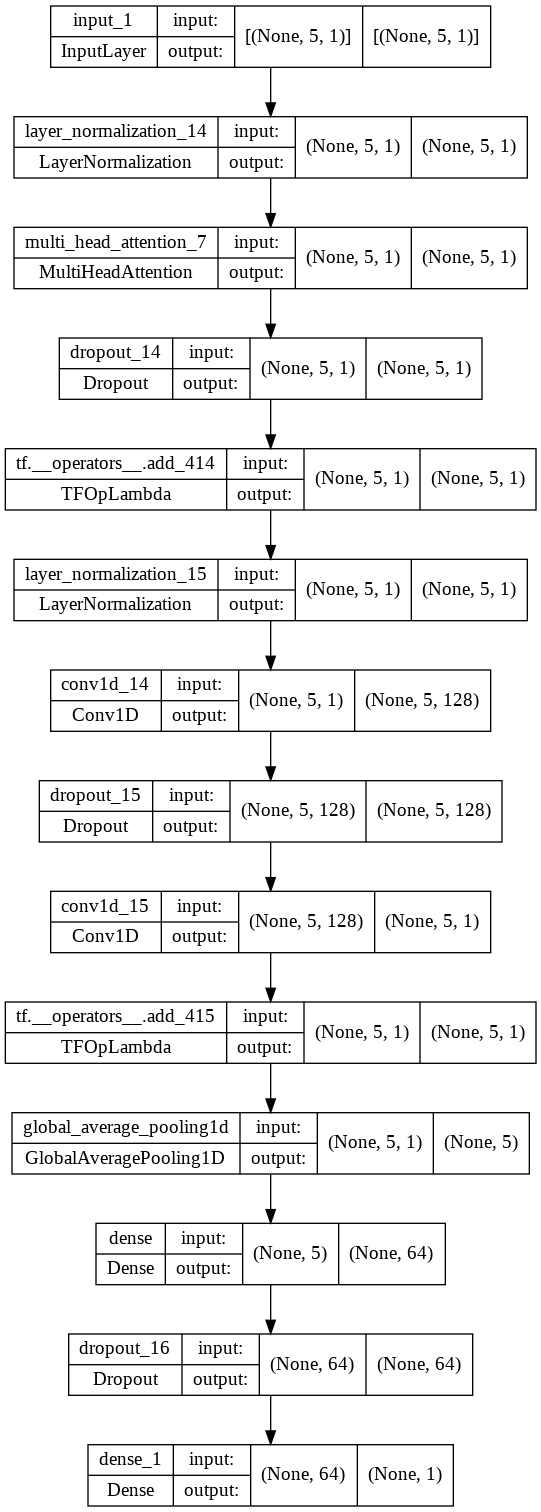

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## 1. Generation of the new data

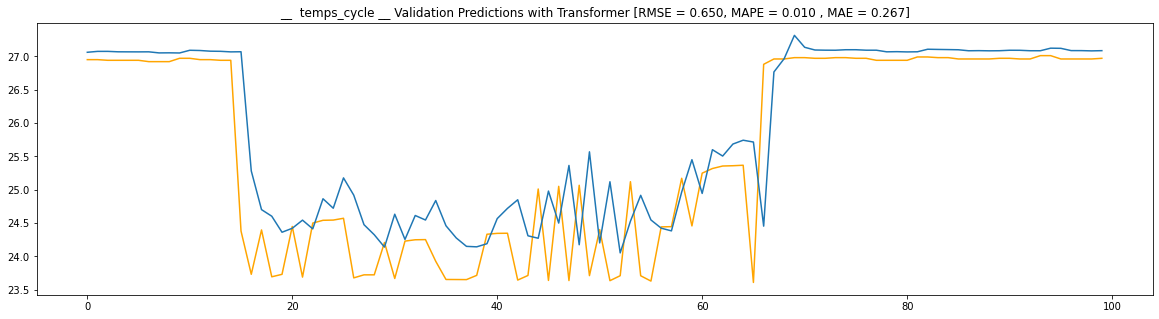

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


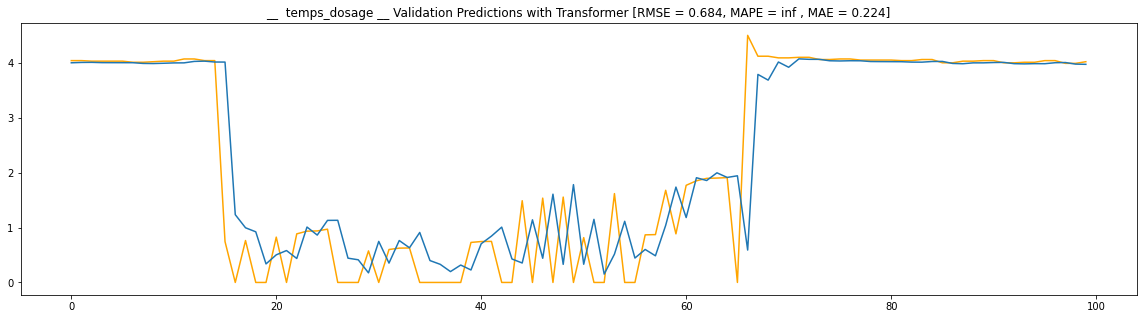

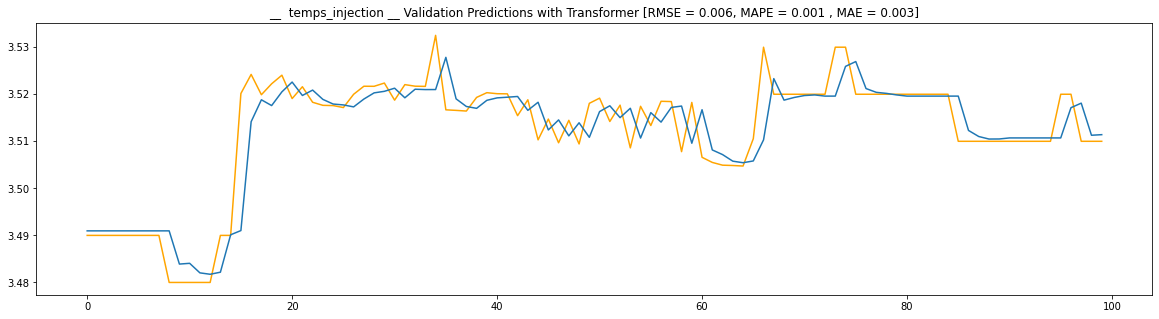

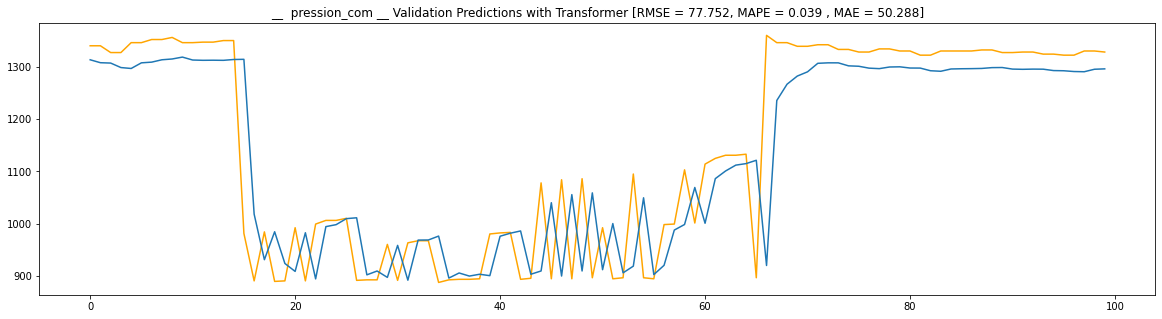

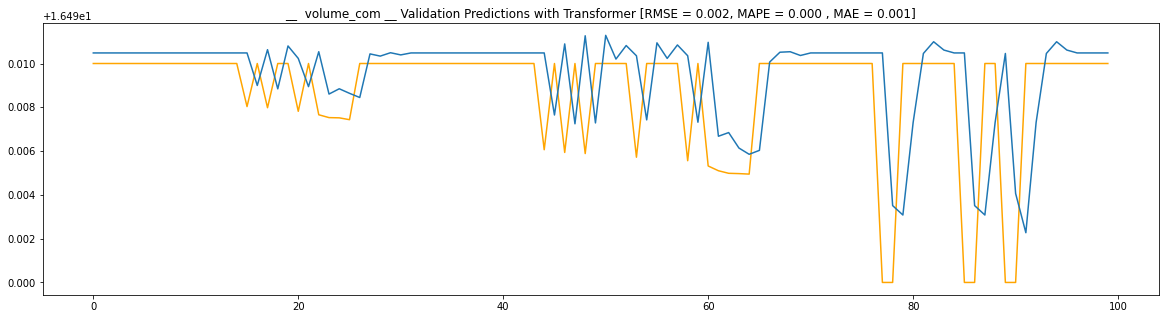

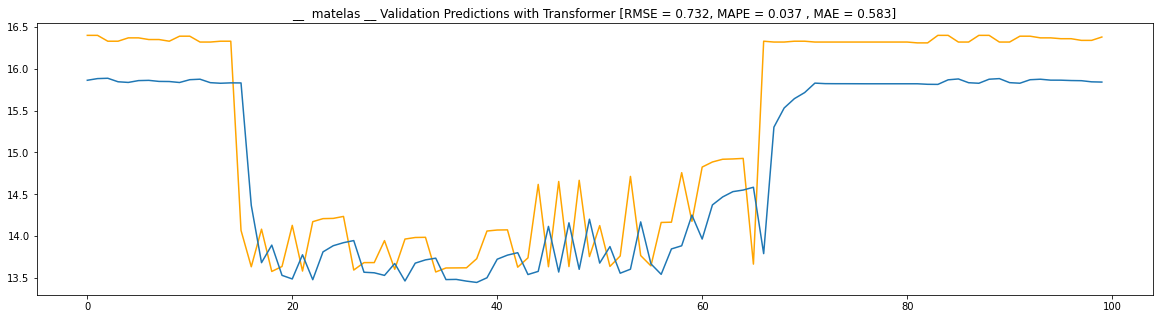

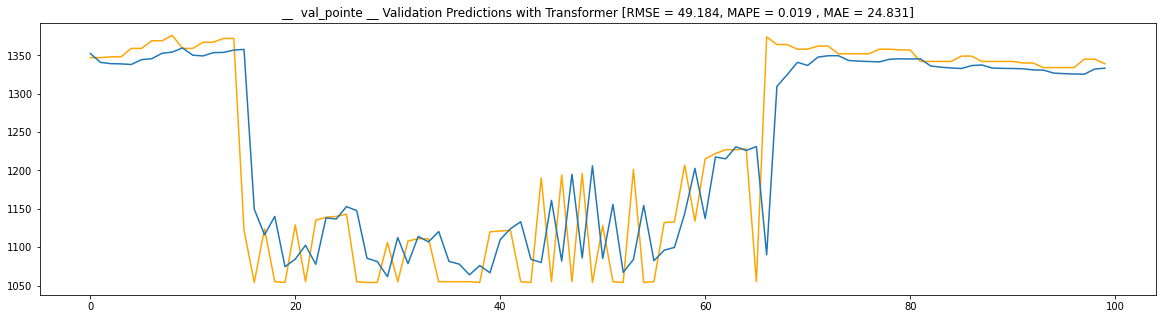

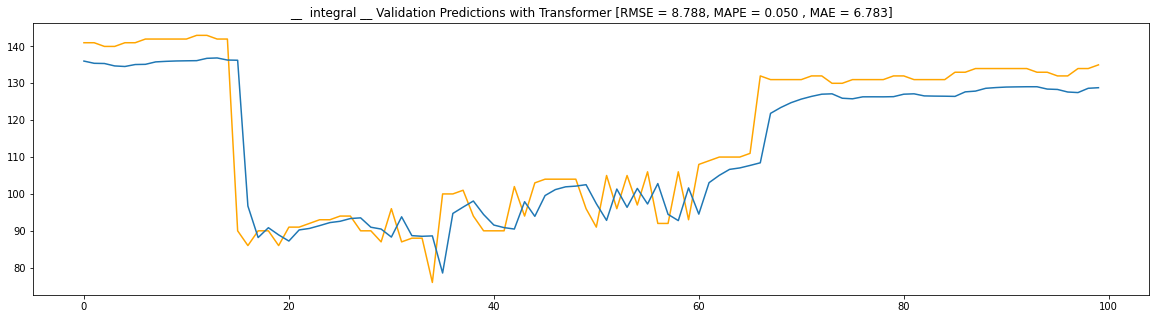

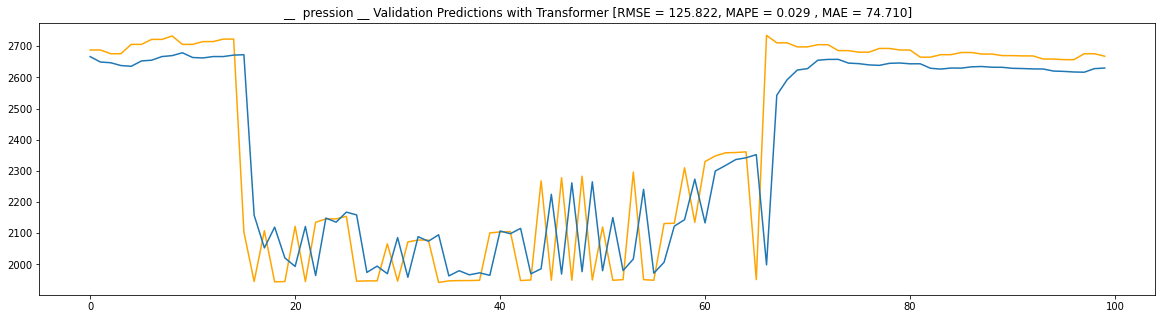

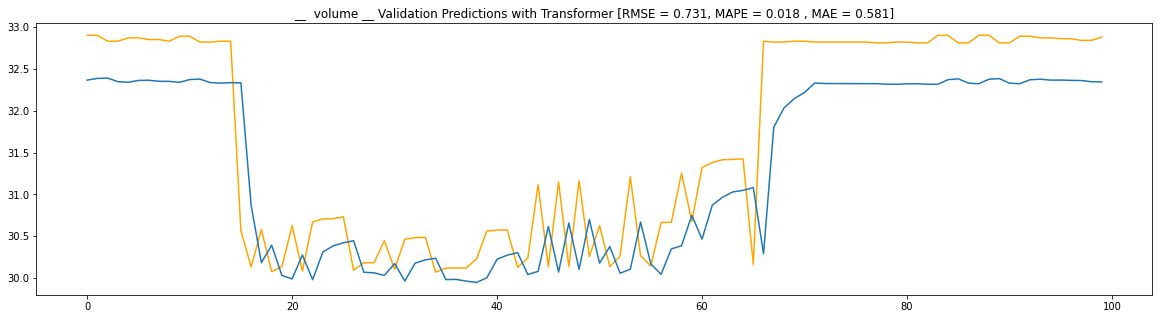

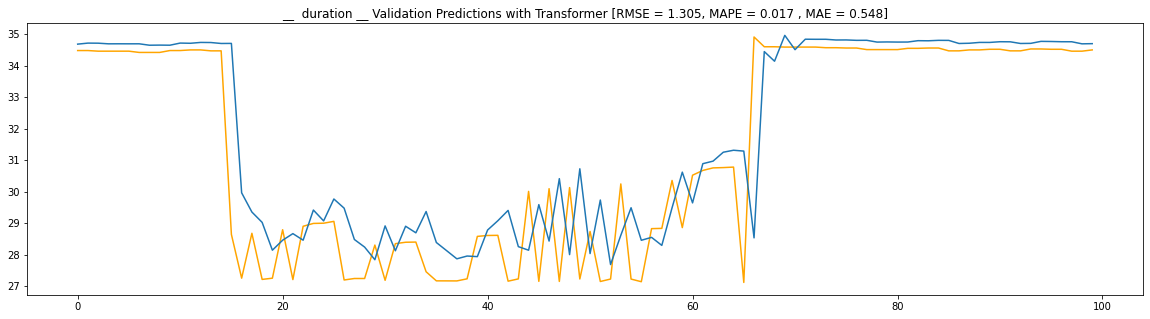

In [ ]:
from pandas._libs.lib import count_level_2d
from sklearn.preprocessing import MinMaxScaler

new_data = []
predictions = []
final_df = pd.DataFrame(new_data)
i = -1

for col in df.columns:
  # Normalization
  values = df[[col]].values

  # Normalization
  scaler = MinMaxScaler()
  scaled_data = scaler.fit_transform(values)

  WINDOW_SIZE = 5

  time_series = scaled_data;
  data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

  # 70% 15% 15%

  X_train_tr, y_train_tr = X[:3935], y[:3935]
  X_test, y_test = X[3935:4775], y[3935:4775]
  X_val, y_val = X[4775:], y[4775:]

  import tensorflow as tf 

  BATCH_SIZE = 256
  BUFFER_SIZE = 10000

  train_univariate = tf.data.Dataset.from_tensor_slices((X_train_tr, y_train_tr))
  train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

  val_univariate = tf.data.Dataset.from_tensor_slices((X_val, y_val))
  val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

  # reshape input to be 3D [samples, timesteps, features]
  X_train_tr = X_train_tr.reshape((X_train_tr.shape[0], WINDOW_SIZE,1))
  X_test = X_test.reshape((X_test.shape[0], WINDOW_SIZE, 1))
  X_val = X_val.reshape((X_val.shape[0], WINDOW_SIZE, 1))
      

  y_pred_val = model.predict(np.asarray(X_val).astype('float32'))
  Inverse_y_pred_val = scaler.inverse_transform(y_pred_val)

  Inverse_y_val = y_val.reshape(-1,1)
  Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
  
  Inverse_X_val = X_val.reshape(-1,1)
  Inverse_X_val = scaler.inverse_transform(Inverse_X_val)

  
  new_col = []
  for val in Inverse_y_pred_val:
    new_col.append(val[0])

  final_df.insert(i+1,col ,new_col)

  mape, mae, rmse = forecast_accuracy(Inverse_y_pred_val, Inverse_y_val)

  fig, ax = plt.subplots(figsize=(20,5))
  plt.plot(Inverse_y_val[0:100], color='orange')
  plt.plot(Inverse_y_pred_val[0:100])
  plt.title("__  %s __ Validation Predictions with Transformer [RMSE = %.3f, MAPE = %.3f , MAE = %.3f]" % (col, rmse, mape, mae) )
  plt.show()

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))
    
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i]);
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step');
    
    return plt

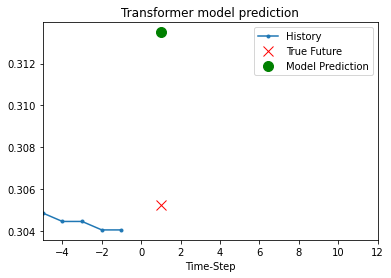

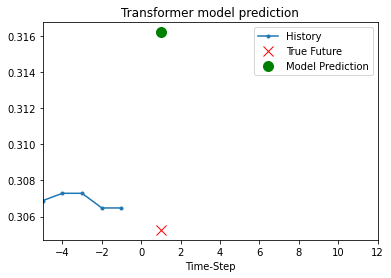

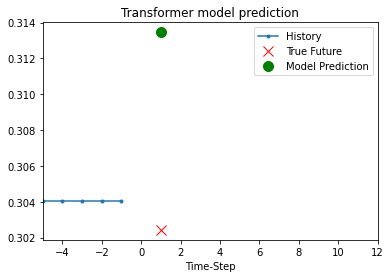

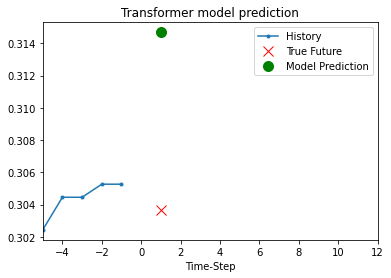

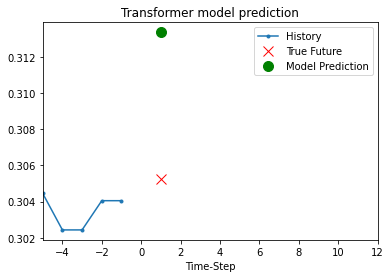

In [ ]:
for x, y in val_univariate.take(5):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 1, 'Transformer model prediction')
    plot.show()

## 2. Classification

In [ ]:
x_train, x_test = final_df[:76866], final_df[76866:]

In [ ]:
x_test.drop('label prediction', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
for col in final_df:
  final_df[col] =final_df[col].apply(lambda x: round(x, 3))

In [ ]:
import pickle

filename = '/content/gdrive/MyDrive/Datascience/PFE/addixo_knn_classifier.sav'
loaded_model = pickle.load(open(filename, 'rb'))

#for testing
if {'label prediction'}.issubset(df.columns): 
  final_df.drop('label prediction', axis=1, inplace=True)

mms = MinMaxScaler()
X_val = mms.fit_transform(final_df)
result = loaded_model.predict(X_val)

final_df.insert(0,"label prediction" ,result)
final_df.head()

,label prediction,duration,volume,pression,integral,val_pointe,matelas,volume_com,pression_com,temps_injection,temps_dosage,temps_cycle
0,1,34.683,32.365,2666.641,136.026,1352.367,15.863,16.5,1314.142,3.491,4.000,27.060
1,1,34.716,32.385,2649.414,135.422,1340.762,15.883,16.5,1308.520,3.491,4.007,27.074
2,1,34.713,32.389,2647.119,135.367,1339.152,15.887,16.5,1307.835,3.491,4.008,27.074
3,1,34.693,32.347,2638.161,134.708,1338.803,15.845,16.5,1299.226,3.491,4.003,27.068
4,1,34.694,32.339,2635.644,134.558,1338.049,15.837,16.5,1297.464,3.491,4.003,27.067


label prediction
0     6044
1    70823
dtype: int64


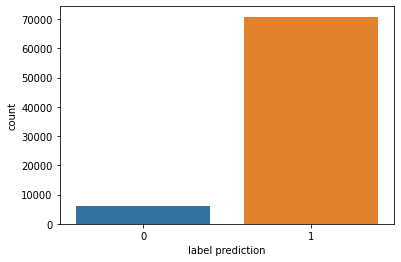

In [ ]:
import seaborn as sns

print(final_df.groupby(['label prediction']).size())
sns.countplot(x ='label prediction', data = final_df)

## 3. Interpretation

Intuitively, an explanation is a local linear approximation of the model's behaviour. While the model may be very complex globally, it is easier to approximate it around the vicinity of a particular instance. While treating the model as a black box, we perturb the instance we want to explain and learn a sparse linear model around it, as an explanation.

LIME interpretation : https://github.com/marcotcr/lime

('Starch Flow <= 2203.11', 0.007104066221272916), <br>
 ('Flotation Column 07 Level > 458.47', -0.004605988469347347),<br>
 ('Flotation Column 06 Level > 491.77', 0.004127897872587883),<br>
 ('Flotation Column 04 Level > 495.48', -0.004090657038231922),<br>
 ('Flotation Column 05 Level > 496.74', -0.00378142401879994),<br>
 ('Flotation Column 03 Level > 599.96', -0.003148344924666014),<br>
 ('Flotation Column 01 Level > 599.53', -0.0022314225278253588),<br>
 ('Flotation Column 02 Level > 598.76', -0.0017148367099924105),<br>
 ('Flotation Column 07 Air Flow > 300.09', 0.0016578746700500096),<br>
 ('% Silica Concentrate <= 1.42', 0.0016517897495015802)

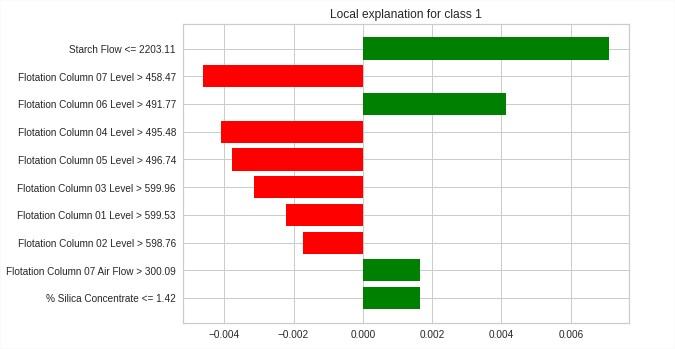 <br> 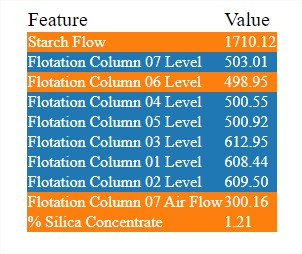<br>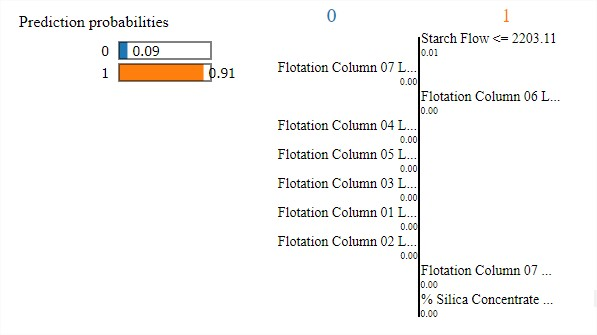